In [14]:
#imports
import pandas as pd
import numpy as np

#API 
import requests

#Automating
import time
import datetime
import warnings
import sys

#sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix

### Build API Function and Collect Data

>Let's write a function (from BH 9-12 )to scale up the previous process to pull many posts, working iteratively backwards using epoch timestamp.

In [15]:
def get_posts(subreddit, n_iter, epoch_right_now): # subreddit name and number of times function should run
    # store base url variable
    base_url = 'https://api.pushshift.io/reddit/search/submission/?subreddit='

    # instantiate empty list    
    df_list = []
    
    # save current epoch, used to iterate in reverse through time
    current_time = epoch_right_now
    
    # set up for loop
    for post in range(n_iter):
        
        # instantiate get request
        res = requests.get(
            
            # requests.get takes base_url and params
            base_url,
            
            # parameters for get request
            params = {
                
                # specify subreddit
                'subreddit' : subreddit,
                
                # specify number of posts to pull
                'size' : 100,
                
                # ???
                'lang' : True,
                
                # pull everything from current time backward
                'before' : current_time }
        )
        
        # take data from most recent request, store as df
        df = pd.DataFrame(res.json()['data'])
        
        # pull specific columns from dataframe for analysis
        df = df.loc[:, ['title',
                        'created_utc', 
                        'selftext',
                        'subreddit',
                        'author',
                        'media_only',
                        'permalink']]
        
        # append to empty dataframe list
        df_list.append(df)
        
        # add wait time
        time.sleep(30)
        
        # set current time counter back to last epoch in recently grabbed df
        current_time = df['created_utc'].min()

    # return one dataframe for all requests
    return pd.concat(df_list, axis=0)
# Adapated from Tim Book's Lesson Example

>1602021145 timestamp now
>
> Two subreddits I have chosen this time are : running, healthy


> Getting the posts (50 iterate everytime 100 posts, totally 5000 posts for each subreddit.)

In [16]:
#running_df=get_posts(subreddit=['running'], n_iter=50, epoch_right_now=1602037481)

In [17]:
#loseit_df=get_posts(subreddit=['loseit'], n_iter=50, epoch_right_now=1602037481)

In [18]:
running_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4851 entries, 0 to 4850
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0.1      4851 non-null   int64 
 1   Unnamed: 0.1.1    4851 non-null   int64 
 2   Unnamed: 0.1.1.1  4851 non-null   int64 
 3   title             4851 non-null   object
 4   created_utc       4851 non-null   int64 
 5   selftext          4851 non-null   object
 6   subreddit         4851 non-null   object
 7   author            4851 non-null   object
 8   media_only        4851 non-null   bool  
 9   permalink         4851 non-null   object
dtypes: bool(1), int64(4), object(5)
memory usage: 383.7+ KB


In [19]:
loseit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4865 entries, 0 to 4864
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0.1      4865 non-null   int64 
 1   Unnamed: 0.1.1    4865 non-null   int64 
 2   Unnamed: 0.1.1.1  4865 non-null   int64 
 3   title             4865 non-null   object
 4   created_utc       4865 non-null   int64 
 5   selftext          4865 non-null   object
 6   subreddit         4865 non-null   object
 7   author            4865 non-null   object
 8   media_only        4865 non-null   bool  
 9   permalink         4865 non-null   object
dtypes: bool(1), int64(4), object(5)
memory usage: 384.8+ KB


In [20]:
running_df['selftext'].value_counts()

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [21]:
running_df.head(2)

,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,title,created_utc,selftext,subreddit,author,media_only,permalink
0,0,0,0,What's your favorite pair of running shoes you...,1602036636,"Sorry if it's been asked a million times, just...",running,jimjamesandjimmy,False,/r/running/comments/j6ik9o/whats_your_favorite...
1,1,1,1,Need help on becoming a better runner.,1602036498,So this post is exactly what the title states....,running,DatNiqqa34,False,/r/running/comments/j6ij2s/need_help_on_becomi...


In [22]:
#exporting to csv file
running_df.to_csv('./CSV files/running.csv')

In [23]:
running_df.drop_duplicates(subset='title', inplace=True)

In [24]:
loseit_df.drop_duplicates(subset='title', inplace=True)

In [25]:
loseit_df['selftext'].value_counts()

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [26]:
loseit_df.head(5)

,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,title,created_utc,selftext,subreddit,author,media_only,permalink
0,0,0,0,One-derland!,1602037278,"F25, been on my journey since my doctor checke...",loseit,Cheddarlishous,False,/r/loseit/comments/j6ipzp/onederland/
1,1,1,1,"My build: 18 year old male, 6 feet tall, 250 p...",1602036340,[removed],loseit,sexyindianguy007,False,/r/loseit/comments/j6ihnh/my_build_18_year_old...
2,2,2,3,40lbs down since February! Feeling excited.,1602035613,[removed],loseit,wgonzale,False,/r/loseit/comments/j6iazo/40lbs_down_since_feb...
3,3,3,4,Weight suddenly shot up? (19F/SW178lbs/CW145lb...,1602034635,[removed],loseit,Yuzhenyi,False,/r/loseit/comments/j6i296/weight_suddenly_shot...
4,4,4,5,Weight suddenly shot up?,1602034447,[removed],loseit,Yuzhenyi,False,/r/loseit/comments/j6i0l1/weight_suddenly_shot...


In [27]:
#exporting to csv file
loseit_df.to_csv('./CSV files/loseit.csv')

In [28]:
running_df=pd.read_csv('./CSV files/running.csv', keep_default_na=False, index_col=0)

In [29]:
loseit_df=pd.read_csv('./CSV files/loseit.csv', keep_default_na=False, index_col=0)

In [30]:
# creating the target value
loseit_df['running']=0
running_df['running']=1

In [31]:
#Merging two dataframes

df=running_df.append(loseit_df, sort=True)
df.drop(columns=['permalink'], inplace=True)

In [32]:
#let's export it to csv and then examine it
df.to_csv('./CSV files/df_loseit_running.csv')

In [33]:
df.tail(3)

,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,author,created_utc,media_only,running,selftext,subreddit,title
4862,4862,4862,97,TheBoredLeo,1599208965,False,0,I think this may one of my favorite NSVs so fa...,loseit,NSV: My progress made a friend start her own w...
4863,4863,4863,98,CobaltWaves,1599207796,False,0,[removed],loseit,NSV - I can no longer hold my phone in between...
4864,4864,4864,99,Dogwarden,1599207441,False,0,I'm trying to lose weight for all the normal r...,loseit,"Hello, first post (I've lurked) and I'm just m..."


In [34]:
#Getting 3 columns of author and is_motivating and title and making author is the index column
df= df[['running', 'title', 'author']]
df.set_index('author', inplace=True)
df

,running,title
author,,
jimjamesandjimmy,1,What's your favorite pair of running shoes you...
DatNiqqa34,1,Need help on becoming a better runner.
dhankook2,1,"Committed ""Casual"" - What Can be Accomplished ..."
zach1424,1,Wanting to change from a power lifter to a runner
sebas9119,1,Do you feel faster at night and slower in the ...
...,...,...
shokaru,0,Staying focused
Sweet-liqourice,0,Struggling to consistently lose weight
TheBoredLeo,0,NSV: My progress made a friend start her own w...


In [35]:
df.index.unique()

Index(['jimjamesandjimmy', 'DatNiqqa34', 'dhankook2', 'zach1424', 'sebas9119',
       'BlamedXmonster', 'mrclarkaddison', 'crimspa', 'waxheartzZz', 'SRV1981',
       ...
       'MeMeSadBlob', 'duplex78', 'qujstionmark', 'District_Free',
       'Paper_Frequent', 'Pleasant_Glow', 'shokaru', 'Sweet-liqourice',
       'TheBoredLeo', 'CobaltWaves'],
      dtype='object', name='author', length=7700)

In [36]:
df.isnull().sum()

running    0
title      0
dtype: int64

In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
running,9716.0,0.49928,0.500025,0.0,0.0,0.0,1.0,1.0


In [38]:
df['running'].nunique()

2

### Word/Tag Cloud
>
>Tags are usually single words, and the importance of each tag is shown with font size or color.

In [39]:
#https://peekaboo-vision.blogspot.com/2012/11/a-wordcloud-in-python.html
from wordcloud import WordCloud, get_single_color_func, ImageColorGenerator, STOPWORDS
from nltk.corpus import stopwords
#stopwords= set(STOPWORDS)
stopWordsListEng = stopwords.words("english")
Minoo_new_stopwords_to_add = ['Michael', 'turkey', 'Ronnie', 'dtype', 'DD', '1t']
stopwords= stopWordsListEng.extend(Minoo_new_stopwords_to_add)


def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=70, 
        scale=5,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=3)

    plt.imshow(wordcloud)
    plt.show()

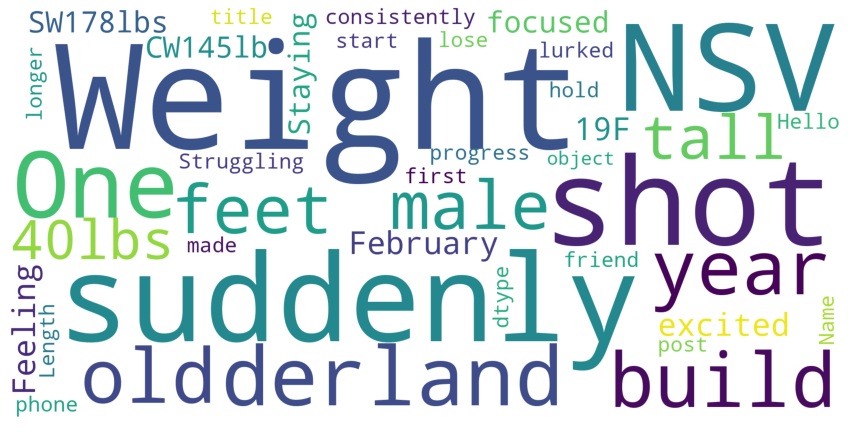

In [40]:
import matplotlib.pyplot as plt
#let's get the word cloud for healthy df
show_wordcloud(loseit_df['title'])

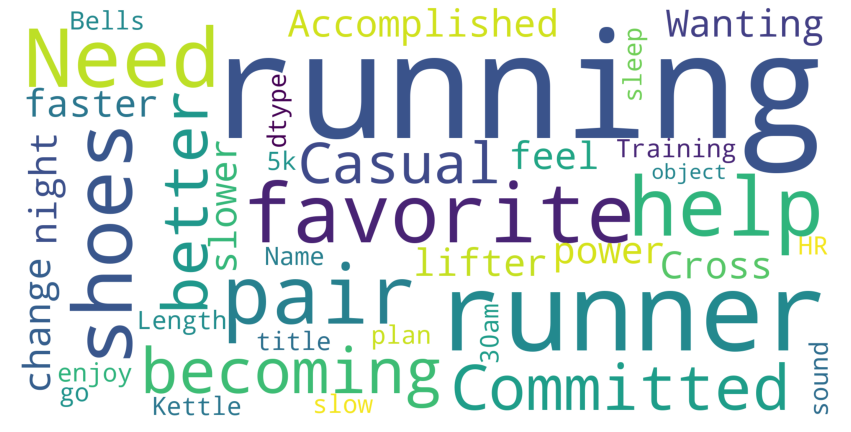

In [41]:
#let's get the word cloud for running df
show_wordcloud(running_df['title'])

### Modeling Data
>Train/Test split

In [42]:
df.reset_index(drop=True, inplace=True)

In [43]:
df

,running,title
0,1,What's your favorite pair of running shoes you...
1,1,Need help on becoming a better runner.
2,1,"Committed ""Casual"" - What Can be Accomplished ..."
3,1,Wanting to change from a power lifter to a runner
4,1,Do you feel faster at night and slower in the ...
...,...,...
9711,0,Staying focused
9712,0,Struggling to consistently lose weight
9713,0,NSV: My progress made a friend start her own w...
9714,0,NSV - I can no longer hold my phone in between...


In [44]:
X=df['title']

In [45]:
y=df['running']

In [46]:
# checking balance of data and baseline accuracy
#the results seems like the data set is in balance!
df['running'].value_counts(normalize=True)

0    0.50072
1    0.49928
Name: running, dtype: float64

In [47]:
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=28, stratify=y)

In [48]:
X_train.shape

(7287,)

In [49]:
y_train

9693    0
487     1
7513    0
6007    0
6019    0
       ..
3812    1
7768    0
6838    0
5404    0
7002    0
Name: running, Length: 7287, dtype: int64


### Preprocessing
> Fitting a count vectorizer to find the most popular words


In [50]:
## Adding more letters and words to stopwords as below:
import nltk
minoo_stopwords = nltk.corpus.stopwords.words('english')
new_words=("`","’","n't", "thi", "anyon")
for i in new_words:
    minoo_stopwords.append(i)

# get this code from http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
from textblob import TextBlob

# Use TextBlob
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

In [51]:
#The resuly for using porterstemmer was not good! the letters like "m" and "t" and "-" were in most common words.
# Use NLTK's PorterStemmer
#def stemming_tokenizer(str_input):
    #words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    #words = [porter_stemmer.stem(word) for word in words]
    #return words

In [52]:
#instantiate and fit and transform our model on CountVectorizer
cvec=CountVectorizer(
        analyzer='word',
        tokenizer=textblob_tokenizer,
        preprocessor= None,
        stop_words=minoo_stopwords)

X_train_cvec=cvec.fit_transform(X_train)
X_test_cvec=cvec.transform(X_test)
X_train_cvec

/Users/minootaghavi/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


<7287x5219 sparse matrix of type '<class 'numpy.int64'>'
	with 39796 stored elements in Compressed Sparse Row format>

In [53]:
#visualizing our train data set
cvec_df= pd.DataFrame(X_train_cvec.todense(),
                     columns=cvec.get_feature_names())

cvec_df

,'apron,'click,'cold,'comfort,'commun,'d,'deserv,'jogger,'ll,'m,...,😔,😭,🙁,🙌,🙏,🙏🏼,🤗,🤡,🤷‍♂️,🥳
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7283,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
columns=cvec.get_feature_names()
columns

["'apron",
 "'click",
 "'cold",
 "'comfort",
 "'commun",
 "'d",
 "'deserv",
 "'jogger",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'sore",
 "'ve",
 "'weight",
 '0',
 '0.4',
 '0/178lb',
 '00:31:49',
 '00:34:10',
 '01',
 '01sweetcandi',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '073',
 '08',
 '09',
 '09/04/2020',
 '1',
 '1,000',
 '1,200/day',
 '1,500',
 '1,700',
 '1-2',
 '1.2',
 '1.2m',
 '1.4',
 '1.4kg',
 '1.5',
 '1.59.26',
 '1/2',
 '10',
 '10,000',
 '10,271',
 '10-12',
 '10-30',
 '10-minut',
 '10.2',
 '10.2kg',
 '10.5',
 '10.8',
 '10/5/2020',
 '100',
 '100+lb',
 '100,000',
 '100-200m',
 '1000',
 '1000cal',
 '1000m',
 '100k',
 '100kg',
 '100km',
 '100lb',
 '100m',
 '100th',
 '104',
 '105kg',
 '105lb',
 '108',
 '1080',
 '109',
 '10:30',
 '10k',
 '10kg',
 '10km',
 '10lb',
 '10m/mi',
 '10mm',
 '10th',
 '10°c/50°f',
 '11',
 '110',
 '1100',
 '1100kcal',
 '110kg',
 '110lbs/50kg',
 '111',
 '111kg',
 '114lb',
 '115',
 '116',
 '118',
 '11:09',
 '11k',
 '11kg',
 '11km',
 '11th',
 '12',
 '12-hour',
 '12.4',


In [55]:
X_train_cvec.todense()


matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [56]:
X_train_cvec

<7287x5219 sparse matrix of type '<class 'numpy.int64'>'
	with 39796 stored elements in Compressed Sparse Row format>

In [57]:
y_train

9693    0
487     1
7513    0
6007    0
6019    0
       ..
3812    1
7768    0
6838    0
5404    0
7002    0
Name: running, Length: 7287, dtype: int64

In [58]:
df


,running,title
0,1,What's your favorite pair of running shoes you...
1,1,Need help on becoming a better runner.
2,1,"Committed ""Casual"" - What Can be Accomplished ..."
3,1,Wanting to change from a power lifter to a runner
4,1,Do you feel faster at night and slower in the ...
...,...,...
9711,0,Staying focused
9712,0,Struggling to consistently lose weight
9713,0,NSV: My progress made a friend start her own w...
9714,0,NSV - I can no longer hold my phone in between...


In [59]:
X_train

9693                               Scale recommendations?
487     Looking for advice about anxiety and dehydrati...
7513      (N)SV: It's okay not to meet your deadlines!!!!
6007                                        Sound torture
6019    I don't know how many calories I should eat in...
                              ...                        
3812    Between big training block/efforts a good time...
7768    How likely am I to have loose skin? (-80/90 lb...
6838    Gained 3.5 inches on my waist, 5 inches on hip...
5404    Top motivational songs| Best workout songs| En...
7002    SV/NSV Feats of the Day - Tuesday, 22 Septembe...
Name: title, Length: 7287, dtype: object

In [60]:
X_train.index

Int64Index([9693,  487, 7513, 6007, 6019, 9378, 6889, 1464, 4254, 6562,
            ...
             753, 3507, 2164, 9390, 2719, 3812, 7768, 6838, 5404, 7002],
           dtype='int64', length=7287)

In [61]:
loseit_vect=pd.DataFrame(X_train_cvec.todense(),
                        columns=cvec.get_feature_names(), index=X_train.index).reindex(y_train[y_train == 0].index)

In [62]:
top_loseit_words= loseit_vect.mean().sort_values(ascending=False).iloc[:15]
top_loseit_words.values

array([0.22828172, 0.12743217, 0.0885174 , 0.06933406, 0.06577144,
       0.06303097, 0.06029049, 0.05700192, 0.05563168, 0.05316525,
       0.04412168, 0.04165525, 0.0413812 , 0.0408331 , 0.03754453])

In [63]:
top_loseit_words=top_loseit_words.sort_values(ascending=False)
top_loseit_words

weight    0.228282
lose      0.127432
loss      0.088517
day       0.069334
help      0.065771
start     0.063031
need      0.060290
calori    0.057002
eat       0.055632
lost      0.053165
get       0.044122
lb        0.041655
feel      0.041381
fat       0.040833
today     0.037545
dtype: float64

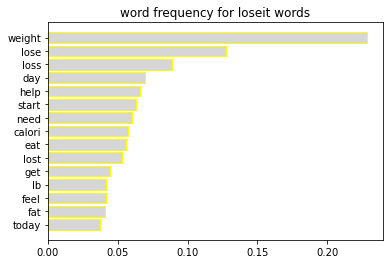

In [64]:
top_loseit_words=top_loseit_words.sort_values(ascending=True)
plt.barh(top_loseit_words.index, top_loseit_words.values, color=(0.2, 0.2, 0.2, 0.2),  edgecolor='Yellow')
plt.title('word frequency for loseit words');

>Plot for RUNNING df words

In [65]:
running_vect=pd.DataFrame(X_train_cvec.todense(),
                        columns=cvec.get_feature_names(), index=X_train.index).reindex(y_train[y_train == 1].index)
top_running_words= running_vect.mean().sort_values(ascending=False).iloc[:15]
top_running_words.values

array([0.42743266, 0.06459593, 0.06294667, 0.0579989 , 0.05277625,
       0.05140187, 0.0475536 , 0.04727872, 0.04617922, 0.04343046,
       0.04343046, 0.03985706, 0.03573392, 0.03518417, 0.03216053])

In [66]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [67]:
top_running_words=top_running_words.sort_values(ascending=False)
top_running_words

run         0.427433
shoe        0.064596
first       0.062947
marathon    0.057999
runner      0.052776
get         0.051402
time        0.047554
train       0.047279
help        0.046179
advic       0.043430
mile        0.043430
need        0.039857
5k          0.035734
new         0.035184
ani         0.032161
dtype: float64

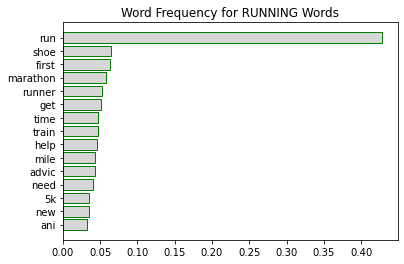

In [68]:
top_running_words=top_running_words.sort_values(ascending=True)
plt.barh(top_running_words.index, top_running_words.values, color=(0.2, 0.2, 0.2, 0.2),  edgecolor='Green')
plt.title('Word Frequency for RUNNING Words');


### Let's fit the model!
>Using Logistic Regression, Random Forest, TF-IDF and GridSearchCV

### Preprocessing: TF-IDF Tool (term frequency–inverse document frequency)


> Trying to do stemming and tokenizing 

In [69]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [70]:
# get this code from http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
## Adding more letters and words to stopwords as below:
import nltk
minoo_stopwords = nltk.corpus.stopwords.words('english')
new_words=("`","’","n't", "thi", "anyon")
for i in new_words:
    minoo_stopwords.append(i)

# get this code from http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
from textblob import TextBlob

# Use TextBlob
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

In [71]:
#Instantiating and fitting the TF-IDF model
tvec= TfidfVectorizer(analyzer='word',
                     tokenizer=textblob_tokenizer,
                     preprocessor=None,
                     stop_words=minoo_stopwords)

X_train_tvec=tvec.fit_transform(X_train)
X_test_tvec=tvec.transform(X_test)
X_train_tvec

<7287x5219 sparse matrix of type '<class 'numpy.float64'>'
	with 39796 stored elements in Compressed Sparse Row format>

In [72]:
tvec_df= pd.DataFrame(X_train_tvec.todense(),
                     columns=tvec.get_feature_names())

tvec_df.head()

,'apron,'click,'cold,'comfort,'commun,'d,'deserv,'jogger,'ll,'m,...,😔,😭,🙁,🙌,🙏,🙏🏼,🤗,🤡,🤷‍♂️,🥳
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.18433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Modeling: Logistic Regression and TFIDF Model

In [73]:
lr_tvec_model=LogisticRegression()

lr_tvec_model.fit(X_train_tvec, y_train)

print(f'Logistic Regression and TFIDF Model Score on Training Set :{lr_tvec_model.score(X_train_tvec, y_train)}')
print(f'Logistic Regression and TFIDF Model Score on Testing Set :{lr_tvec_model.score(X_test_tvec, y_test)}')

Logistic Regression and TFIDF Model Score on Training Set :0.9544394126526692
Logistic Regression and TFIDF Model Score on Testing Set :0.9065459036640593


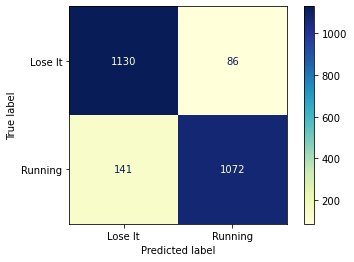

In [74]:
plot_confusion_matrix(lr_tvec_model, X_test_tvec, y_test, cmap='YlGnBu', display_labels=['Lose It', 'Running']);

In [76]:
#let's get the coefficients and find the top 10 coefficients and plot them!
X_df=pd.DataFrame(X_train_tvec.sum(), index=tvec.get_feature_names(), columns=['count'])
X_df['coef']=lr_tvec_model.coef_.T

In [77]:
#let's see if we have any null values...
X_df.isnull().sum()

count    0
coef     0
dtype: int64

In [78]:
top_10_coef=X_df.sort_values(by=['coef'], ascending=False).abs()
top_10_coef_sorted=top_10_coef.sort_values(by=['coef'], ascending=False).head(20)
top_10_coef_sorted

,count,coef
run,15816.880159,13.348937
runner,15816.880159,5.631862
weight,15816.880159,5.381175
shoe,15816.880159,4.941360
marathon,15816.880159,4.726689
mile,15816.880159,4.297711
5k,15816.880159,4.029416
lose,15816.880159,3.888452
nsv,15816.880159,3.815961
train,15816.880159,3.722293


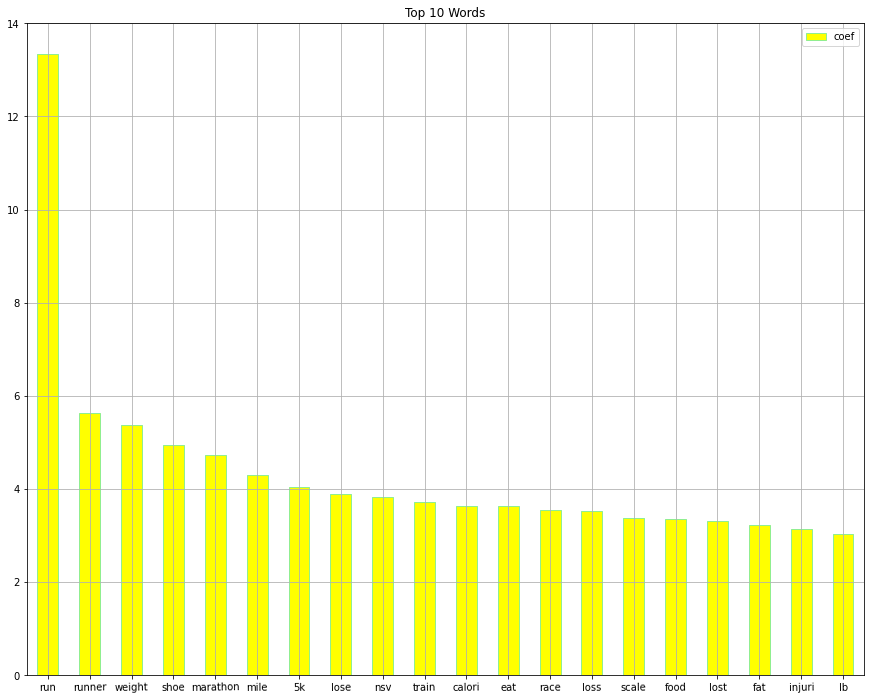

In [79]:
top_10_coef_sorted['coef'].plot.bar(
                        rot = 1, 
                        figsize=(15,12),
                        grid=True,
                        legend=True,
                        fontsize=10,
                        title="Top 10 Words",
                        color='Yellow',  
                        edgecolor='Lightgreen');

### Modeling: Naive Bayes and TFIDF Model

In [80]:
nbayes_tvec_model=MultinomialNB()

nbayes_tvec_model.fit(X_train_tvec, y_train)

print(f'Naive Bayes and TFIDF Model Score on Training Set :{nbayes_tvec_model.score(X_train_tvec, y_train)}')
print(f'Logistic Regression and TFIDF Model Score on Testing Set :{nbayes_tvec_model.score(X_test_tvec, y_test)}')

Naive Bayes and TFIDF Model Score on Training Set :0.9459311101962399
Logistic Regression and TFIDF Model Score on Testing Set :0.9057225195553725


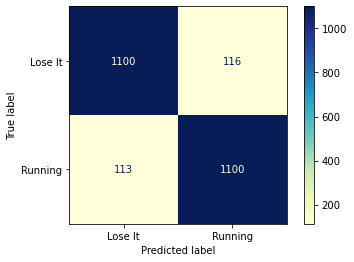

In [81]:
plot_confusion_matrix(nbayes_tvec_model, X_test_tvec, y_test, cmap='YlGnBu', display_labels=['Lose It', 'Running']);

### Preprocessing: Count Vectorizer tool

In [82]:
cvec=CountVectorizer(stop_words=minoo_stopwords, ngram_range=[1, 4])

In [83]:
X_train_cvec=cvec.fit_transform(X_train)

In [84]:
X_test_cvec=cvec.transform(X_test)

In [85]:
cvec_df= pd.DataFrame(X_train_cvec.todense(),
                     columns=cvec.get_feature_names())

cvec_df.head()

,00,00 31,00 31 49,00 34,00 34 10,00 34 10 time,00 beginning,00 beginning october,00 cw,00 cw 83,...,zoom,zoom fly,zoom pegasus,zoom pegasus turbo,zoom tempo,zoom tempo next,zoom tempo next looks,zoom tempo next vs,zumba,zwift
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Modeling: Logistic Regression and CountVectorizer Model

In [86]:
lr_cvec_model=LogisticRegression()

lr_cvec_model.fit(X_train_cvec, y_train)

print(f'Logistic Regression and CountVectorizer Model Score on Training Set :{lr_cvec_model.score(X_train_cvec, y_train)}')
print(f'Logistic Regression and CountVectorizer Model Score on Testing Set :{lr_cvec_model.score(X_test_cvec, y_test)}')

Logistic Regression and CountVectorizer Model Score on Training Set :0.9901193906957596
Logistic Regression and CountVectorizer Model Score on Testing Set :0.9114862083161795


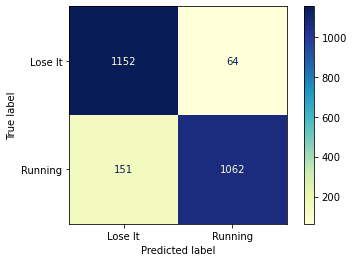

In [87]:
plot_confusion_matrix(lr_cvec_model, X_test_cvec, y_test, cmap='YlGnBu', display_labels=['Lose It', 'Running']);

### Modeling: Naive Bayes and CountVectorizer Model

In [88]:
nbayes_cvec_model=MultinomialNB()

nbayes_cvec_model.fit(X_train_cvec, y_train)

print(f'Naive Bayes and cvec Model Score on Training Set :{nbayes_cvec_model.score(X_train_cvec, y_train)}')
print(f'Logistic Regression and cvec Model Score on Testing Set :{nbayes_cvec_model.score(X_test_cvec, y_test)}')

Naive Bayes and cvec Model Score on Training Set :0.9813366268697681
Logistic Regression and cvec Model Score on Testing Set :0.9164265129682997


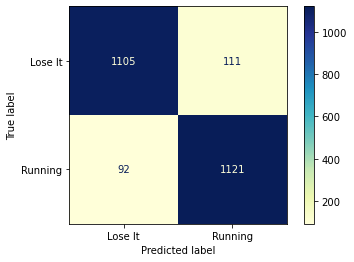

In [89]:
plot_confusion_matrix(nbayes_cvec_model, X_test_cvec, y_test, cmap='YlGnBu', display_labels=['Lose It', 'Running']);

### Let's initiate and fit the model through GridSearchCV and Pipe

In [90]:
nbayes=MultinomialNB()
pipe=make_pipeline(tvec, nbayes)
pipe

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function textblob_tokenizer at 0x7fce82430dc0>)),
                ('multinomialnb', MultinomialNB())])

In [91]:
params={
       'tfidfvectorizer__max_features': [2000, 3000, 4000, 5000], 
          'tfidfvectorizer__stop_words': [minoo_stopwords, None],
         'tfidfvectorizer__ngram_range': [(1, 2), (1, 1)]
    
}

In [92]:
#grid
grid=GridSearchCV(pipe, param_grid=params)
#fit it
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
          

In [93]:
# Score model on training and testing set.
print(f'Grid model score on training data: {grid.score(X_train, y_train)}')
print(f'Grid model score on training data: {grid.score(X_test, y_test)}')

Grid model score on training data: 0.9442843419788665
Grid model score on training data: 0.9065459036640593


In [109]:
len(X_test)

2429

In [107]:
test_pred= pd.DataFrame(preds, index=X_test)

In [108]:
test_pred

,0
title,
How to stay motivated during winter?,0
Virtual London marathon this Sunday,1
Ankle pain,1
How to avoid painfull blisters on my feet,1
I took a cheat day too hard...,0
...,...
Hoka EVO Speedgoat vs Hoka Torrent 2 vs Peg 36 Trail?,1
"How fast is ""running"" - non-english speaker",1
Question from a teenager,0


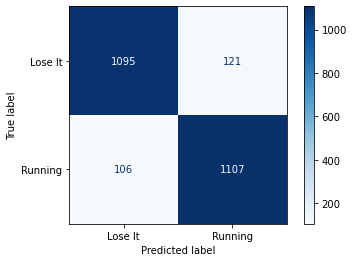

In [96]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# Get predictions
preds = grid.predict(X_test)
# Save confusion matrix values
cmat2 = confusion_matrix(y_test, preds)
plot_confusion_matrix(grid,  X_test, y_test,cmap='Blues', display_labels=['Lose It', 'Running']);

### Let's try Random Forest Classifier Model 

In [322]:
#Instantiating and fitting the Ranfom Forest Classifier model
rfc=RandomForestClassifier()

params={
    'n_estimators': [50, 100, 150, 200],
    
}

rfc_gs=GridSearchCV(estimator=rfc,
                   param_grid=params,
                   cv=5,
                   verbose=1,
                   n_jobs=-1)

rfc_gs= rfc_gs.fit(X_train_tvec, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   19.9s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.1s finished


In [323]:
print(f'Random Forest GridSearchCV Best Score:{rfc_gs.best_score_}')
print(f'Random Forest GridSearchCV Best Parameters:{rfc_gs.best_params_}')

Random Forest GridSearchCV Best Score:0.9033885890262514
Random Forest GridSearchCV Best Parameters:{'n_estimators': 200}


In [324]:
rfc_gs.best_estimator_.feature_importances_

array([3.13057528e-07, 0.00000000e+00, 1.17179495e-07, ...,
       1.03670940e-06, 4.52070938e-06, 1.46034790e-05])

In [325]:
# Let's find the importance for each word
word_importance=zip(tvec.get_feature_names(), rfc_gs.best_estimator_.feature_importances_);
sorted(word_importance, key=lambda x: abs(x[1]), reverse=True)


[('run', 0.15524621791264892),
 ('weight', 0.04486671959665222),
 ('lose', 0.02167373465645185),
 ('runner', 0.019252940810692263),
 ('shoe', 0.018589773601331325),
 ('marathon', 0.015907622302296073),
 ('loss', 0.013886280881856386),
 ('calori', 0.012206286468768392),
 ('eat', 0.011764313720367911),
 ('train', 0.011169835820248632),
 ('mile', 0.010721664301300799),
 ('5k', 0.010640467188888647),
 ('lost', 0.00964838346147974),
 ('race', 0.008665674566655103),
 ('fat', 0.00834883220959202),
 ('pain', 0.007380458521797263),
 ('diet', 0.007305916668999455),
 ('nsv', 0.007005945868705482),
 ('food', 0.006934009289620804),
 ('lb', 0.006811769892647551),
 ('injuri', 0.005931558147116707),
 ('scale', 0.005884741504968601),
 ('knee', 0.005469230197814614),
 ('ran', 0.00521692904051813),
 ('pound', 0.0050030099849967865),
 ('treadmil', 0.004752632488717074),
 ('start', 0.004641108900536117),
 ('first', 0.004614625347772193),
 ('plateau', 0.00443241595549726),
 ('journey', 0.004275056311243444)

In [326]:
predict=rfc_gs.predict(X_test_tvec)
rfc_gs.score(X_test_tvec, y_test)

0.892136681762042

In [327]:
predict

array([0, 1, 1, ..., 0, 0, 1])

### My Random Forest Model has the training score of %90 and testing score of 89%.

### Let's try more pipelines for Logistic regression and TFIDF, CountVectorizer tools.

> Logistic Regression Model and TFIDFVectorizer tool

In [329]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

pipe.fit(X_train, y_train)

# Evaluate how your model will perform on unseen data
print(f' Cross_val_score is: {cross_val_score(pipe, X_train, y_train, cv=3).mean()}') 
# Training score
print(f' Training Score is: {pipe.score(X_train, y_train)}')
# Test score
print(f' Test Score is: {pipe.score(X_test, y_test)}')

 Cross_val_score is: 0.9013311376423769
 Training Score is: 0.955400027446137
 Test Score is: 0.9110745162618361


> Logistic Regression Model and CountVectorizer tool

In [331]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe.fit(X_train, y_train)

# Evaluate how your model will perform on unseen data
print(f' Cross_val_score is: {cross_val_score(pipe, X_train, y_train, cv=3).mean()}') 
# Training score
print(f' Training Score is: {pipe.score(X_train, y_train)}')
# Test score
print(f' Test Score is: {pipe.score(X_test, y_test)}')

 Cross_val_score is: 0.9005077535336902
 Training Score is: 0.9700837107177165
 Test Score is: 0.9081926718814327


> GridSearchCV and pipe 

In [332]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500, 10_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8998216001097846


{'cvec__max_df': 0.9,
 'cvec__max_features': 10000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [334]:
print(f'GridSearchCV score on Training Dataset :{gs.score(X_train, y_train)}')
print(f'GridSearchCV score on Testing Dataset :{gs.score(X_test, y_test)}')


GridSearchCV score on Training Dataset :0.9791409359132702
GridSearchCV score on Testing Dataset :0.9040757513379992
